In [6]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy.stats import zscore
from statsmodels.stats.multitest import multipletests
import tableone as tb
import warnings

warnings.simplefilter(action='ignore')

from src.pathology.core import (determine_amyloid_status, compute_roi_amyloid, compute_roi_tau)
from src.pathology.laterality import (laterality_index, calculate_regional_laterality)
from src.pathology.cutoffs import (find_gmm_cutoff, is_above_cutoff)
from src.connectomics.atlases import get_dk_rois
from src.analysis.misc import set_plot_style
from src.analysis.plots import plot_regression
from src.analysis.surf import plot_surface

set_plot_style(dpi=150)
ROIs = get_dk_rois()

# in
data_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'data'))
df_dir = os.path.join(data_dir, 'external_cohorts')

# out
media_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'media'))

plot_dir = os.path.join(media_dir, '_plots')
surfplot_dir = os.path.join(plot_dir, 'surfs')
os.makedirs(surfplot_dir, exist_ok=True)

def add_prefix(df, prefix:str, id_col='sid', ):
    return df.rename(columns={col: f"{prefix}_{col}" for col in df.columns if col != id_col})
def replace_hyphen_with_underscore(df):
    return df.rename(columns={col: col.replace('-', '_') for col in df.columns})

In [8]:
# analysis ROIs of interest
y_roi = 'global_LI'
ylabel = 'Global tau laterality'

x_roi = 'global_LI'
xlabel = 'Global Aβ laterality'

# tau and amyloid PET variable prefixes
amy_prefix = 'fnc'
tau_prefix = 'tnic'

# tau and amyloid positivity ROIs and cutoffs
tau_roi = 'temporal_meta'
tau_cutoff = 1.34
amy_roi = 'global'
amy_cutoff = 1.11

cohort_dict = {
    # Open Access Series of Imaging Studies
    'OASIS-3': {
        'dir': os.path.join(df_dir, 'oasis'),
        'tau_file_date': '221101', # [18F] flortaucipir PET
        'amy_file_date': '220929', # [18F] florbetapir PET
        'demo_filename': 'OASIS_colin.csv',
        'rename_demo_cols': {'ID':'sid', 'Age_at_tau_PET': 'age', 'Sex': 'sex', 'Education_years': 'edu', 
                             'Amyloid_status': 'amyloid_positive', 'Clinical_diagnosis': 'ci'},
        'sex_map': {'f': 1, 'm': 0},
        'diagnosis_map': {'Cognitively normal': 0, 'No dementia': 0, 'AD Dementia': 1, 'uncertain dementia': 1,
                          '"AD dem w/depresss': 1, 'AD dem w/PDI after AD dem not contrib': 1,
                          'AD dem Language dysf after': 1, '0.5 in memory only': 1},
        'amy_pos': 1,
    },
    # Anti-Amyloid Treatment in Asymptomatic Alzheimer's Disease
    'A4': {
        'dir': os.path.join(df_dir, 'a4'),
        'tau_file_date': '221027', # [18F] flortaucipir PET
        'amy_file_date': '220916', # [18F] florbetapir PET
        'demo_filename': 'A4_PTDEMOG_PRV2_06Nov2023.csv',
        'rename_demo_cols': {'BID':'sid', 'PTAGE': 'age', 'PTGENDER': 'sex', 'PTEDUCAT': 'edu'}, # no amyloid or diagnosis cols
        'sex_map': {2: 1, 1: 0},
        'amy_pos': 1,
    },
    # Alzheimer's Disease Neuroimaging Initiative
    'ADNI': {
        'dir': os.path.join(df_dir, 'adni'),
        'tau_file_date': '220314', # [18F] flortaucipir PET
        'amy_file_date': '220314', # [18F] florbetapir PET 
        'demo_filename': 'ADNI_tauPET_with_all_info.xlsx',
        'rename_demo_cols': {'PTID.x':'sid',  'AGE': 'age', 'PTGENDER': 'sex', 'PTEDUCAT': 'edu', 
                             'AMYLOID_STATUS': 'amyloid_positive', 'SCANDATE_tau':'scan_tnic', 'DX': 'ci'},
        'sex_map': {'Female': 1, 'Male': 0},
        'diagnosis_map': {'CN': 0, 'MCI': 1, 'Dementia': 1},
        'amy_pos': 1,
    }
}

In [9]:
df_all = pd.DataFrame()
for cohort, c_dict in cohort_dict.items():
    print(f'cohort: {cohort}')

    ### read data

    # amyloid PET

    df_fnc_fs_sr = pd.read_csv(os.path.join(c_dict['dir'], amy_prefix, f"sr_mr_fs_{c_dict['amy_file_date']}.csv"), low_memory=False)
    df_fnc_fs_sr = add_prefix(df_fnc_fs_sr, prefix='fnc_sr_mr_fs', id_col='sid')
    df_fnc_fs_sr = replace_hyphen_with_underscore(df_fnc_fs_sr)

    df_fnc_fs_vx = pd.read_csv(os.path.join(c_dict['dir'], amy_prefix, f"vx_mr_fs_{c_dict['amy_file_date']}.csv"), low_memory=False)
    df_fnc_fs_vx = add_prefix(df_fnc_fs_vx, prefix='fnc_vx_fs', id_col='sid')
    df_fnc_fs_vx = replace_hyphen_with_underscore(df_fnc_fs_vx)

    df_fnc = df_fnc_fs_sr.merge(df_fnc_fs_vx, on='sid', how='outer')

    # tau PET

    df_tnic_fs_sr = pd.read_csv(os.path.join(c_dict['dir'], tau_prefix, f"sr_mr_fs_{c_dict['tau_file_date']}.csv"), low_memory=False)
    df_tnic_fs_sr = add_prefix(df_tnic_fs_sr, prefix=f'{tau_prefix}_sr_mr_fs', id_col='sid')
    df_tnic_fs_sr = replace_hyphen_with_underscore(df_tnic_fs_sr)

    df_tnic_fs_vx = pd.read_csv(os.path.join(c_dict['dir'], tau_prefix, f"vx_mr_fs_{c_dict['tau_file_date']}.csv"), low_memory=False)
    df_tnic_fs_vx = add_prefix(df_tnic_fs_vx, prefix=f'{tau_prefix}_vx_fs', id_col='sid')
    df_tnic_fs_vx = replace_hyphen_with_underscore(df_tnic_fs_vx)

    df_tnic = df_tnic_fs_sr.merge(df_tnic_fs_vx, on='sid', how='outer')

    # ADNI-specific (due to longitudinal dataset)
    if cohort == 'ADNI':
        df_fnc['scan'] = df_fnc['sid'].apply(lambda x: int(x.split('__')[-1]))
        df_fnc['sid'] = df_fnc['sid'].apply(lambda x: '__'.join(x.split('__')[:-1]))
        df_fnc['scan'] = pd.to_datetime(df_fnc['scan'].astype(int).astype(str))

        df_tnic['scan'] = df_tnic['sid'].apply(lambda x: int(x.split('__')[-1]))
        df_tnic['sid'] = df_tnic['sid'].apply(lambda x: '__'.join(x.split('__')[:-1]))
        df_tnic['scan'] = pd.to_datetime(df_tnic['scan'].astype(int).astype(str))

        df = pd.merge(df_fnc, df_tnic, how='inner', on='sid', suffixes=['_fnc', '_tnic'])
        df['scan_diff'] = abs(df['scan_fnc'] - df['scan_tnic'])
        df = df.loc[df.groupby('sid')['scan_diff'].idxmin()]
        df = df.loc[df['scan_diff']<='365 days']
    else:
        df = pd.merge(df_fnc, df_tnic, how='inner', on='sid')

    # demographics

    if c_dict['demo_filename'].endswith('.csv'):
        df_demo = pd.read_csv(os.path.join(c_dict['dir'], c_dict['demo_filename']))
    else:
        df_demo = pd.read_excel(os.path.join(c_dict['dir'], c_dict['demo_filename']))
    df_demo = df_demo.rename(columns=c_dict['rename_demo_cols'])
    df_demo['sex'] = df_demo['sex'].map(c_dict['sex_map'])

    if cohort == 'A4':
        df_demo = df_demo[['sid', 'age', 'sex', 'edu']]
        df_demo['ci'] = 0
        df = pd.merge(df, df_demo, on='sid', how='inner')
    elif cohort == 'ADNI':
        df_demo['scan_tnic'] = pd.to_datetime(df_demo['scan_tnic'].str.replace('%%%', '-', regex=False))
        df_demo = df_demo[['sid', 'scan_tnic', 'age', 'sex', 'edu', 'amyloid_positive', 'ci']]
        df_demo['ci'] = df_demo['ci'].map(c_dict['diagnosis_map'])
        df_demo = df_demo.dropna(subset='ci')
        df = pd.merge(df, df_demo, on=['sid', 'scan_tnic'], how='inner')
    else:
        df_demo = df_demo[['sid', 'age', 'sex', 'edu', 'amyloid_positive', 'ci']]
        df_demo['ci'] = df_demo['ci'].map(c_dict['diagnosis_map'])
        df_demo = df_demo.dropna(subset='ci')
        df = pd.merge(df, df_demo, on='sid', how='inner')
        
    # study cohort selection

    taupet_cols = [
        col for col in df.columns 
        if (col.startswith(f'{tau_prefix}_sr_mr_fs_ctx_') and 'unknown' not in col) or 
        (col.startswith(f'{tau_prefix}_sr_mr_fs_') and ('Hippocampus' in col or 'Amygdala' in col))
    ]
    amypet_cols = [
        col for col in df.columns 
        if (col.startswith(f'{amy_prefix}_sr_mr_fs_ctx_') and 'unknown' not in col) or 
        (col.startswith(f'{amy_prefix}_sr_mr_fs_') and ('Hippocampus' in col or 'Amygdala' in col))
    ]

    df = df.dropna(subset=taupet_cols)
    print(f"N (cohort selection) = {df.shape}")

    ### pathology

    # PET averages in all defined ROIs for both hemispheres
    for ROI_name, ROI_regions in ROIs.items():
        # amyloid-PET
        df[f'{amy_prefix}_{ROI_name}_left'] = compute_roi_amyloid(df, ROI_regions, ['_lh_', '_Left'])
        df[f'{amy_prefix}_{ROI_name}_right'] = compute_roi_amyloid(df, ROI_regions, ['_rh_', '_Right'])
        df[f'{amy_prefix}_{ROI_name}'] = compute_roi_amyloid(df, ROI_regions, ['_lh_', '_Left', '_rh_', '_Right'])
        # amyloid laterality index
        df[f'{amy_prefix}_{ROI_name}_LI'] = df.apply(lambda row: laterality_index(
            row[f'{amy_prefix}_{ROI_name}_left'], row[f'{amy_prefix}_{ROI_name}_right']), axis=1)
        
        # tau-PET
        df[f'{tau_prefix}_{ROI_name}_left'] = compute_roi_tau(df, ROI_regions, ['_lh_', '_Left'])
        df[f'{tau_prefix}_{ROI_name}_right'] = compute_roi_tau(df, ROI_regions, ['_rh_', '_Right'])
        df[f'{tau_prefix}_{ROI_name}'] = compute_roi_tau(df, ROI_regions, ['_lh_', '_Left', '_rh_', '_Right'])
        # tau laterality index
        df[f'{tau_prefix}_{ROI_name}_LI'] = df.apply(lambda row: laterality_index(
            row[f'{tau_prefix}_{ROI_name}_left'], row[f'{tau_prefix}_{ROI_name}_right']), axis=1)
    
    df = calculate_regional_laterality(df, amypet_cols, prefix=f"fnc_", suffix="_LI")
    df = calculate_regional_laterality(df, taupet_cols, prefix=f"{tau_prefix}_", suffix="_LI")
    print(f"N (ROI-based laterality) = {df.shape}")

    # amyloid-PET cut-off and positivity
    if 'amyloid_positive' not in df.columns:
        if amy_cutoff == None:
            amy_cutoff = find_gmm_cutoff(scores_gmm=df[f'{amy_prefix}_{amy_roi}'].to_numpy(), 
                                        roi_name=f'{amy_prefix}_{amy_roi}', verbose=True, plot_gmm=False)
            print(amy_cutoff)
        df['amyloid_positive'] = df.apply(determine_amyloid_status, axis=1, pet_col=f'{amy_prefix}_{amy_roi}', 
                                        cutoff=amy_cutoff, csf_ratio_col=None)

    # tau-PET cutoff and positivity
    if tau_cutoff == None:
        tau_cutoff = find_gmm_cutoff(scores_gmm=df[f'{tau_prefix}_{tau_roi}'].to_numpy(), 
                                    roi_name=f'{tau_prefix}_{tau_roi}', verbose=True, plot_gmm=False)
    df['tau_positive'] = is_above_cutoff(df[f'{tau_prefix}_temporal_meta_left'], tau_cutoff) | \
        is_above_cutoff(df[f'{tau_prefix}_temporal_meta_right'], tau_cutoff)

    # amyloid and tau positive
    df = df.loc[(df['amyloid_positive']==c_dict['amy_pos'])]
    print(f"N (A+) = {df.shape}")
    df = df.loc[(df['tau_positive']==1)]
    print(f"N (A+T+) = {df.shape}")

    # final removal of NaN amy-PET
    df = df.dropna(subset=amypet_cols)
    print(f"N (A+T+, drop NaN) = {df.shape}")

    df['cohort'] = cohort
    df['cohort_str'] = f'{cohort} (n={len(df)})'
    # df_all = pd.concat([df_all, df[['sid', 'age', 'sex', 'cohort', 'cohort_str', f'{tau_prefix}_{x_roi}', f'{amy_prefix}_{y_roi}']]]).reset_index(drop=True)
    df_all = pd.concat([df_all, df]).reset_index(drop=True)

cohort: OASIS-3
N (cohort selection) = (415, 472)
N (ROI-based laterality) = (415, 680)
N (A+) = (143, 681)
N (A+T+) = (46, 681)
N (A+T+, drop NaN) = (46, 681)
cohort: A4
N (cohort selection) = (446, 475)
N (ROI-based laterality) = (446, 683)
N (A+) = (356, 685)
N (A+T+) = (55, 685)
N (A+T+, drop NaN) = (55, 685)
cohort: ADNI
N (cohort selection) = (592, 481)
N (ROI-based laterality) = (592, 689)
N (A+) = (285, 690)
N (A+T+) = (134, 690)
N (A+T+, drop NaN) = (133, 690)


In [10]:
var_order = ['age', 'sex', 'edu', 'ci', 'tnic_temporal_meta', 'fnc_global']
var_cat = ['sex', 'ci']

var_notnorm = ['tnic_temporal_meta', 'fnc_global']

rename_vars = {
    'age': 'Age', 
    'sex': 'Sex', 
    'edu': 'Education years',
    'ci': 'Cognitive impairment', 
    'tnic_temporal_meta': 'Temporal tau load', 
    'fnc_global': 'Global Aβ load',
}
    
table = tb.TableOne(data=df_all,
                    # data
                    groupby='cohort_str',
                    columns=var_order,
                    categorical=var_cat,
                    # continuous=var_cont,
                    include_null=True,
                    # visual
                    rename=rename_vars,
                    label_suffix=True,
                    decimals=2,
                    missing=True,
                    overall=False,
                    # tests
                    dip_test=True,
                    normal_test=True,
                    tukey_test=True,
                    # stats
                    nonnormal=var_notnorm,
                    htest_name=True,
                    pval=True,
                    pval_adjust=None,
                    )

display(table)
table.to_excel(os.path.join(media_dir, 'extcoh_demographics.xlsx'))

Grouped by cohort_str                                                                              
                                                    Missing         A4 (n=55)      ADNI (n=133)    OASIS-3 (n=46) P-Value            Test
n                                                                          55               133                46                        
Age, mean (SD)                                            0      72.65 (5.06)      72.39 (6.72)      74.61 (6.77)   0.123   One-way ANOVA
Sex, n (%)                        0.0                              21 (38.18)        56 (42.11)        21 (45.65)   0.748     Chi-squared
                                  1.0                              34 (61.82)        77 (57.89)        25 (54.35)                        
Education years, mean (SD)                                0      16.60 (2.66)      15.69 (2.40)      15.78 (2.60)   0.073   One-way ANOVA
Cognitive impairment, n (%)       0.0                             55 (100.00)        23 (17.29)        15 (32.61)  <0.001     Chi-squared
                                  1.0                                               110 (82.71)        31 (67.39)                        
Temporal tau load, median [Q1,Q3]                         0  1.38 [1.34,1.46]  1.57 [1.39,1.82]  1.57 [1.45,1.85]  <0.001  Kruskal-Wallis
Global Aβ load, median [Q1,Q3]                            0  1.37 [1.27,1.46]  1.42 [1.32,1.53]  1.40 [1.27,1.59]   0.241  Kruskal-Wallis
[1] Hartigan's Dip Test reports possible
                                    multimodal distributions for: edu.
[2] Normality test reports non-normal
                                    distributions for: edu, fnc_global, tnic_temporal_meta.

### plotting

CI (combined) = [0.425, 0.645]
CI (ADNI) = [0.386, 0.683]
CI (A4) = [0.516, 0.913]
CI (OASIS-3) = [0.208, 0.789]


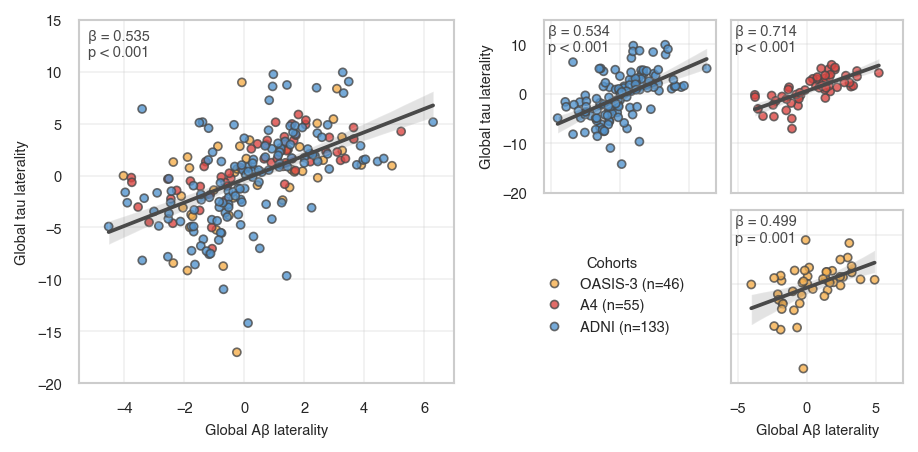

In [11]:
statann_kwargs = dict(fontsize=7, color='#494949')
scatter_kwargs = dict(s=15, lw=0.8, alpha=0.8, edgecolor='#494949', color='#9f9f9f')
legend_kwargs = dict( loc='lower right', bbox_to_anchor=(1.65, 0.1), title='Cohorts', title_fontsize=7, frameon=False)
# badlands @ https://python-graph-gallery.com/color-palette-finder/
palette = {f"ADNI (n={sum(df_all['cohort']=='ADNI')})": '#5495CFFF',
           f"OASIS-3 (n={sum(df_all['cohort']=='OASIS-3')})": '#F5AF4DFF', 
           f"A4 (n={sum(df_all['cohort']=='A4')})": '#DB4743FF'}
ylims, xlims = [-20, 15], [-5.5, 7] # global

x = f'{amy_prefix}_{x_roi}'
y = f'{tau_prefix}_{y_roi}'

fig = plt.figure(figsize=(180/25.4, 80/25.4))
gs = fig.add_gridspec(2, 4, width_ratios=[1.85, 0.3, 0.85, 0.85], height_ratios=[1, 1], wspace=0.075, hspace=0.1)

common_args = dict(x=x, y=y, covars=['age', 'sex', 'ci'], standardise=True, vars2std=[x, y, 'age'], 
                   xlabel=xlabel, ylabel=ylabel, palette=palette, hue='cohort_str', 
                   text_kwargs=statann_kwargs, scatter_kwargs=scatter_kwargs)

# combined plot

ax_left = fig.add_subplot(gs[:, 0])
_, ax_left, m = plot_regression(df=df_all, ax=ax_left, legend_kwargs=legend_kwargs, **common_args)
# ax_left.set_title(f'External cohorts (n={len(df_all)})')
ax_left.set_ylim(ylims)
ax_left.set_xlim(xlims)

cis = m.conf_int()
ci_x = cis.loc[cis.index==x]
print(f"CI (combined) = {[round(float(ci_x[0]), 3), round(float(ci_x[1]), 3)]}")

# spacer
ax_blank = fig.add_subplot(gs[:, 1])
ax_blank.set_axis_off()

# cohorts separately
cohorts = ['ADNI', 'A4', 'OASIS-3']
positions = [(0,2), (0,3), (1,3)]

for cohort, (row, col) in zip(cohorts, positions):
    try:
        ax = fig.add_subplot(gs[row, col])
        cohort_data = df_all[df_all['cohort']==cohort]
        _, ax, m = plot_regression(df=cohort_data, ax=ax, **common_args)
        ax.get_legend().remove()
        # ax.set_title(cohort_data['cohort_str'].iloc[0])
        cis = m.conf_int()
        ci_x = cis.loc[cis.index==x]
        print(f"CI ({cohort}) = {[round(float(ci_x[0]), 3), round(float(ci_x[1]), 3)]}")
    except:
        pass
    ax.set_ylim(ylims)
    ax.set_xlim(xlims)

    if col != 2: 
        ax.set_ylabel('')
        ax.set_yticklabels([])
    if row != 1: 
        ax.set_xlabel('')
        ax.set_xticklabels([])


plt.tight_layout()
plt.savefig(os.path.join(plot_dir, f'OLS_ab_{x_roi}_tau_{y_roi}_extcoh.pdf'), format='pdf', bbox_inches='tight', dpi=300)
plt.show()

cohort: OASIS-3


{'L_cuneus': 0.44287712848250904,
 'L_lateraloccipital': 0.45769136088072915,
 'L_fusiform': 0.3674853370320183,
 'L_superiorparietal': 0.45717296549226133,
 'L_lingual': 0.34379208575513986,
 'L_posteriorcingulate': 0.5712839155165247,
 'L_superiorfrontal': 0.48876783489838516,
 'L_postcentral': 0.4294823027094761,
 'L_paracentral': 0.42992047150995105,
 'L_lateralorbitofrontal': 0.413941521808278,
 'L_inferiortemporal': 0.51520634643885,
 'L_inferiorparietal': 0.5022914204614767,
 'L_isthmuscingulate': 0.4086116201499998,
 'L_caudalmiddlefrontal': 0.5266631376504387,
 'L_precuneus': 0.44911775442399576,
 'L_pericalcarine': 0.42250295848446834,
 'L_superiortemporal': 0.4547220574583281,
 'L_precentral': 0.4191114871726869,
 'L_middletemporal': 0.47815543752680273}

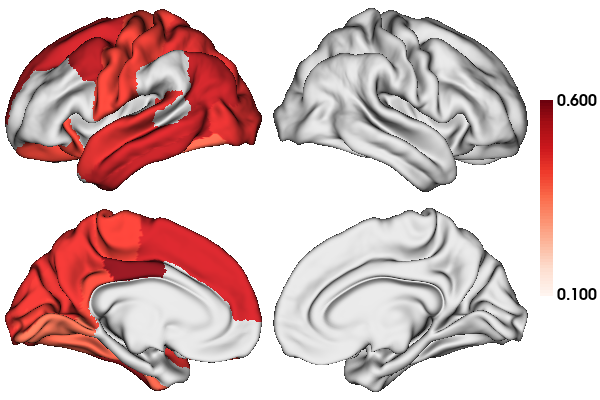

cohort: A4


{'L_entorhinal': 0.2995291185763864,
 'L_cuneus': 0.5490601357428981,
 'L_transversetemporal': 0.5700758486247134,
 'L_lateraloccipital': 0.5854438159527721,
 'L_rostralanteriorcingulate': 0.34858922211670595,
 'L_fusiform': 0.5103075162798784,
 'L_superiorparietal': 0.45344924495301586,
 'L_lingual': 0.4585784935992231,
 'L_posteriorcingulate': 0.4665424236693661,
 'L_superiorfrontal': 0.4853675578226459,
 'L_insula': 0.38912147881614256,
 'L_parsopercularis': 0.5599984528561236,
 'L_postcentral': 0.5869346741767579,
 'L_parsorbitalis': 0.3015548242215734,
 'L_bankssts': 0.556264606642532,
 'L_supramarginal': 0.5968750148131119,
 'L_paracentral': 0.3997245739595839,
 'L_lateralorbitofrontal': 0.36772817250506795,
 'L_inferiortemporal': 0.5036459636602922,
 'L_inferiorparietal': 0.657234847016898,
 'L_temporalpole': 0.3592254930487424,
 'L_isthmuscingulate': 0.48034027821661834,
 'L_caudalmiddlefrontal': 0.5520789736447276,
 'L_rostralmiddlefrontal': 0.3216061427684837,
 'L_frontalpole

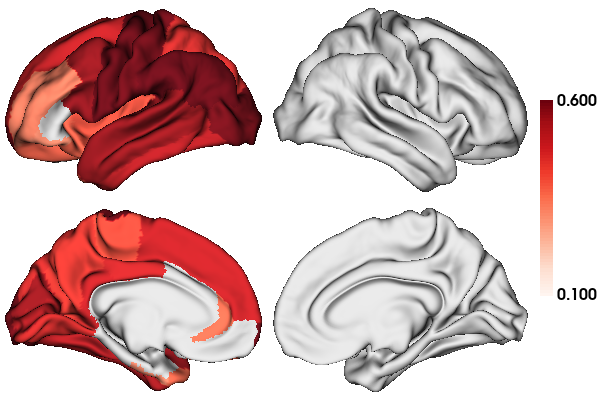

cohort: ADNI


{'L_parstriangularis': 0.2956316734742467,
 'L_entorhinal': 0.4745233700827707,
 'L_cuneus': 0.43769977732177867,
 'L_transversetemporal': 0.36825520071226564,
 'L_lateraloccipital': 0.4681003204884674,
 'L_rostralanteriorcingulate': 0.22237220761269094,
 'L_fusiform': 0.6441363952472527,
 'L_superiorparietal': 0.47968982093704704,
 'L_lingual': 0.5478184982467285,
 'L_posteriorcingulate': 0.4895257400322489,
 'L_superiorfrontal': 0.3409687891591887,
 'L_insula': 0.34172608943485094,
 'L_parsopercularis': 0.24057527381441465,
 'L_caudalanteriorcingulate': 0.31072455287912454,
 'L_Amygdala': 0.35479897367979873,
 'L_postcentral': 0.48011485728907194,
 'L_parsorbitalis': 0.29720167281108734,
 'L_bankssts': 0.45464777973775805,
 'L_supramarginal': 0.3589670984327692,
 'L_paracentral': 0.31853964274368307,
 'L_lateralorbitofrontal': 0.2775400363031696,
 'L_inferiortemporal': 0.6697159638679976,
 'L_inferiorparietal': 0.43551737782716377,
 'L_temporalpole': 0.386755489380711,
 'L_isthmuscin

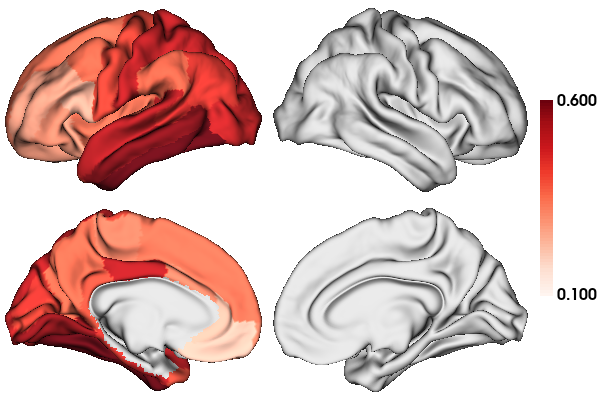

In [12]:
fnc_li_cols = [col for col in df_all.columns if ('LI' in col and 'fnc' in col and any(region in col for region in ROIs['global']))]
tnic_li_cols = [col for col in df_all.columns if ('LI' in col and 'tnic' in col and any(region in col for region in ROIs['global']))]

for cohort in cohort_dict.keys():
    print(f'cohort: {cohort}')
    df_ = df_all[df_all['cohort']==cohort]

    fnc_tnic_b = {}
    for region in ROIs['global']:
        # find matching columns for the current region
        fnc_col = next((col for col in fnc_li_cols if region in col), None)
        tnic_col = next((col for col in tnic_li_cols if region in col), None)

        try:
            # prepare data and optionally z-score
            df_v = df_[[fnc_col, tnic_col] + ['age', 'sex']]
            df_v = zscore(df_v)
            
            # OLS regression and extract the parameters for the main predictor
            model = sm.OLS(df_v[tnic_col], sm.add_constant(df_v[[fnc_col] + ['age', 'sex']])).fit()
            b, pval = model.params[fnc_col], model.pvalues[fnc_col]
        except:
            b, pval = np.nan, np.nan
        fnc_tnic_b[region] = {'b': b, 'pval': pval}

    # apply FDR correction
    fnc_tnic_b_fdr = fnc_tnic_b.copy()
    non_nan_pvals = {region: info['pval'] for region, info in fnc_tnic_b_fdr.items() if not np.isnan(info['pval'])}
    _, pvals_fdr, _, _ = multipletests(list(non_nan_pvals.values()), alpha=0.05, method='fdr_bh')

    for i, reg in enumerate(non_nan_pvals.keys()):
        fnc_tnic_b_fdr[reg]['pval_fdr'] = pvals_fdr[i]

    for reg, info in fnc_tnic_b_fdr.items():
        if 'pval_fdr' not in info:
            fnc_tnic_b_fdr[reg]['pval_fdr'] = np.nan

    fnc_tnic_b_fdr = {f"L_{region}": values['b'] for region, values in fnc_tnic_b_fdr.items() if values['pval_fdr'] < 0.05}
    display(fnc_tnic_b_fdr)
    
    # plot surface
    export_kwargs = dict(nan_color=(0.8, 0.8, 0.8, 1), zoom=1.65, transparent_bg=False, scale=5)
    embed_kwargs = dict(nan_color=(0.8, 0.8, 0.8, 1), zoom=1.65, transparent_bg=False, scale=1)
    fig_args = dict(data=fnc_tnic_b_fdr, atlas='aparc', cmap='Reds', cmap_range=(0.1, 0.6), layout_style='grid')
    fig_surf = plot_surface(**fig_args, plot_kwargs=embed_kwargs)
    _ = plot_surface(**fig_args, plot_kwargs=export_kwargs, output=os.path.join(surfplot_dir, f'surf_ab_LI_tau_LI_betas_ext_{cohort}.png'))
    display(fig_surf)

abstract

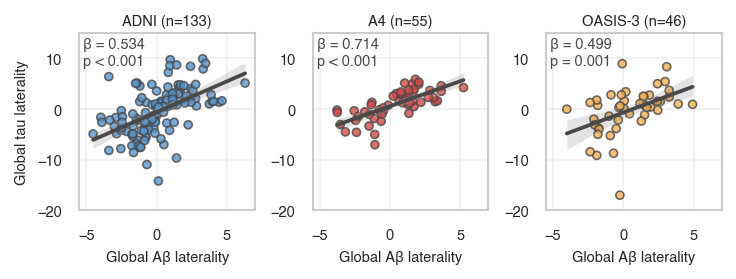

In [13]:
statann_kwargs = dict(fontsize=7, color='#494949')
scatter_kwargs = dict(s=15, lw=0.8, alpha=0.8, edgecolor='#494949', color='#9f9f9f')
legend_kwargs = dict( loc='lower right', bbox_to_anchor=(1.65, 0.1), title='Cohorts', title_fontsize=7, frameon=False)
palette = {f"ADNI (n={sum(df_all['cohort']=='ADNI')})": '#5495CFFF',
           f"OASIS-3 (n={sum(df_all['cohort']=='OASIS-3')})": '#F5AF4DFF', 
           f"A4 (n={sum(df_all['cohort']=='A4')})": '#DB4743FF'}
ylims, xlims = [-20, 15], [-5.5, 7] # global

x = f'{amy_prefix}_{x_roi}'
y = f'{tau_prefix}_{y_roi}'

fig = plt.figure(figsize=(125/25.4, 47.5/25.4))
gs = fig.add_gridspec(1, 3)#, wspace=0.075, hspace=0.1)

common_args = dict(x=x, y=y, covars=['age', 'sex', 'ci'], standardise=True, vars2std=[x, y, 'age'], 
                   xlabel=xlabel, ylabel=ylabel, palette=palette, hue='cohort_str', 
                   text_kwargs=statann_kwargs, scatter_kwargs=scatter_kwargs)


# cohorts separately
cohorts = ['ADNI', 'A4', 'OASIS-3']
positions = [0, 1, 2]

for cohort, col in zip(cohorts, positions):
    try:
        ax = fig.add_subplot(gs[col])
        cohort_data = df_all[df_all['cohort']==cohort]
        _, ax, _ = plot_regression(df=cohort_data, ax=ax, **common_args)
        ax.get_legend().remove()
        ax.set_title(cohort_data['cohort_str'].iloc[0], y=0.975)
    except:
        pass
    ax.set_ylim(ylims)
    ax.set_xlim(xlims)

    # if col != 2: 
    #     ax.set_xlabel('')
    #     ax.set_xticklabels([])
    if col != 0: 
        ax.set_ylabel('')


plt.tight_layout()
plt.savefig(os.path.join(plot_dir, f'abstract_OLS_ab_{x_roi}_tau_{y_roi}_extcoh.pdf'), format='pdf', bbox_inches='tight', dpi=300)
plt.show()